Source: 

https://www.tensorflow.org/tutorials/text/nmt_with_attention

https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/text/nmt_with_attention.ipynb#scrollTo=DUQVLVqUE1YW

# Data Preprocessing

In [1]:
# !which pip 
# !pip install tensorflow==2.4.0
# !conda install -y nomkl

In [2]:
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time

### Download Data

In [3]:
# Download the file
dataset_url = 'http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip'
#TODO: Use wget instead
path_to_zip = tf.keras.utils.get_file('spa-eng.zip', 
                                      origin=dataset_url,
                                      extract=True)

path_to_file = os.path.dirname(path_to_zip)+"/spa-eng/spa.txt"

2646016/2638744 [==============================] - 0s 0us/step


### Define and test necessary functions for preprocessing

In [4]:
# Converts the unicode file to ascii
def unicode_to_ascii(s):
    mylist = []
    for c in unicodedata.normalize('NFD', s):
        if unicodedata.category(c) != 'Mn':
            mylist.append(c)
    
    return ''.join(mylist)


In [5]:
#TODO: arguement name should be "sentence"
def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())

    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)

    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

    w = w.strip()

    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    w = '<start> ' + w + ' <end>'
    return w

In [6]:
en_sentence = u"May I borrow this book?"
sp_sentence = u"¿Puedo tomar prestado este libro?"
print(preprocess_sentence(en_sentence))
print(preprocess_sentence(sp_sentence).encode('utf-8'))

<start> may i borrow this book ? <end>
b'<start> \xc2\xbf puedo tomar prestado este libro ? <end>'


### Define and test necessary functions for dataset creation and tokenization

In [7]:
# 1. Remove the accents
# 2. Clean the sentences
# 3. Return word pairs in the format: [ENGLISH, SPANISH]
def create_dataset(path, num_examples):
    corpus = io.open(path, encoding='UTF-8').read().strip()
    lines = corpus.split('\n')
    
    pairs = []
    for line in lines[:num_examples]:
        pair = []
        for sentence in line.split('\t'):
            pair.append(preprocess_sentence(sentence))
        pairs.append(pair)
    
    return zip(*pairs)

In [8]:
en, sp = create_dataset(path_to_file, None)
print(en[-1])
print(sp[-1])

<start> if you want to sound like a native speaker , you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo . <end>
<start> si quieres sonar como un hablante nativo , debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un musico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado . <end>


In [9]:
def tokenize(sentences):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    
    tokenizer.fit_on_texts(sentences)
    tensor = tokenizer.texts_to_sequences(sentences)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                           padding='post')

    return tensor, tokenizer

In [10]:
def load_dataset(path, num_examples=None):
    
    targ_sentences, inp_sentences = create_dataset(path, num_examples)

    input_tensor, inp_lang_tokenizer = tokenize(inp_sentences)
    target_tensor, targ_lang_tokenizer = tokenize(targ_sentences)

    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

Limit Data Size

In [11]:
# Try experimenting with the size of that dataset
num_examples = 30000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num_examples)

# Calculate max_length of the target tensors
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]

Train - Validation Split

In [ ]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Show length
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

24000 24000 6000 6000


Function for printing the string forms of the words, together with index forms

In [ ]:
def convert(tokenizer_object, tensor):
    for t in tensor:
        if t!=0:
            print (f"Index: {t} \t\t Word: {tokenizer_object.index_word[t]}")
        else:
            print(f"Index: {t} \t\t Word: <pad>")

In [ ]:
print ("Input Language; index to word mapping \n")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping \n")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping 

Index: 1 		 Word: <start>
Index: 350 		 Word: hazlo
Index: 45 		 Word: como
Index: 17 		 Word: se
Index: 23 		 Word: te
Index: 475 		 Word: dice
Index: 3 		 Word: .
Index: 2 		 Word: <end>
Index: 0 		 Word: <pad>
Index: 0 		 Word: <pad>
Index: 0 		 Word: <pad>
Index: 0 		 Word: <pad>
Index: 0 		 Word: <pad>
Index: 0 		 Word: <pad>
Index: 0 		 Word: <pad>
Index: 0 		 Word: <pad>

Target Language; index to word mapping 

Index: 1 		 Word: <start>
Index: 22 		 Word: do
Index: 10 		 Word: it
Index: 219 		 Word: as
Index: 6 		 Word: you
Index: 24 		 Word: are
Index: 257 		 Word: told
Index: 3 		 Word: .
Index: 2 		 Word: <end>
Index: 0 		 Word: <pad>
Index: 0 		 Word: <pad>


### Forming a Tensorflow Dataset

In [ ]:
DATASET_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024

vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(DATASET_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [ ]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 16]), TensorShape([64, 11]))

# The Model and Attention

TODO: Change the attention layer

In [ ]:
class Encoder(tf.keras.Model):
    
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')

    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)
        return output, state

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

In [ ]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print (f'Encoder output shape: (batch size, sequence length, units)\n {sample_output.shape}')
print (f'Encoder Hidden state shape: (batch size, units)\n {sample_hidden.shape}')

Encoder output shape: (batch size, sequence length, units)
 (64, 16, 1024)
Encoder Hidden state shape: (batch size, units)
 (64, 1024)


In [ ]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size)
        
        #Optional: Implement attention yourself
        # self.attention = BahdanauAttention(self.dec_units)

        self.attention = tf.keras.layers.AdditiveAttention(causal = False)

    def call(self, x, hidden, enc_output):
        # enc_output shape == (batch_size, max_length, hidden_size)

        # query [batch_size, Tq, dim]
        # value [batch_size, Tv, dim]
        # key   [batch_size, Tv, dim]

        hidden = tf.expand_dims(hidden, 1)
        context_vector, attention_weights = self.attention([hidden,enc_output,enc_output], return_attention_scores = True)
        context_vector = tf.squeeze(context_vector, axis=1)
        attention_weights = tf.squeeze(attention_weights, axis=1)

        #Optional: Implement attention yourself
        # context_vector, attention_weights = self.attention(hidden, enc_output)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # passing the concatenated vector to the GRU
        output, state = self.gru(x)

        # output shape == (batch_size * 1, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))

        # output shape == (batch_size, vocab)
        x = self.fc(output)

        return x, state, attention_weights

In [ ]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 4935)


# Training

### Optimizer

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

### Checkpoints

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

### Training Loop

In [ ]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [ ]:
EPOCHS = 10

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 4.7354
Epoch 1 Batch 100 Loss 2.0503
Epoch 1 Batch 200 Loss 1.9122
Epoch 1 Batch 300 Loss 1.7876
Epoch 1 Loss 2.0349
Time taken for 1 epoch 37.439743518829346 sec

Epoch 2 Batch 0 Loss 1.4886
Epoch 2 Batch 100 Loss 1.5555
Epoch 2 Batch 200 Loss 1.3503
Epoch 2 Batch 300 Loss 1.3298
Epoch 2 Loss 1.3505
Time taken for 1 epoch 27.849825620651245 sec

Epoch 3 Batch 0 Loss 1.0936
Epoch 3 Batch 100 Loss 0.9828
Epoch 3 Batch 200 Loss 0.9025
Epoch 3 Batch 300 Loss 0.9779
Epoch 3 Loss 0.9181
Time taken for 1 epoch 27.34834885597229 sec

Epoch 4 Batch 0 Loss 0.6248
Epoch 4 Batch 100 Loss 0.5829
Epoch 4 Batch 200 Loss 0.5850
Epoch 4 Batch 300 Loss 0.6494
Epoch 4 Loss 0.5912
Time taken for 1 epoch 27.96310043334961 sec

Epoch 5 Batch 0 Loss 0.4483
Epoch 5 Batch 100 Loss 0.3760
Epoch 5 Batch 200 Loss 0.3543
Epoch 5 Loss 0.3830
Time taken for 1 epoch 27.874132871627808 sec

Epoch 6 Batch 0 Loss 0.2927
Epoch 6 Batch 200 Loss 0.2235
Epoch 6 Batch 300 Loss 0.2453
Epoch 6 Loss 0.2563

# Inference and Evaluation

In [ ]:
def evaluate(sentence):
  attention_plot = np.zeros((max_length_targ, max_length_inp))

  sentence = preprocess_sentence(sentence)

  inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  hidden = [tf.zeros((1, units))]
  enc_out, enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

  for t in range(max_length_targ):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

    # storing the attention weights to plot later on
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy()

    result += targ_lang.index_word[predicted_id] + ' '

    if targ_lang.index_word[predicted_id] == '<end>':
      return result, sentence, attention_plot

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot

In [ ]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [ ]:
def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))

### Load Checkpoint

In [ ]:
1

1

In [ ]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <start> hace mucho frio aqui . <end>
Predicted translation: it s too cold here . <end> 


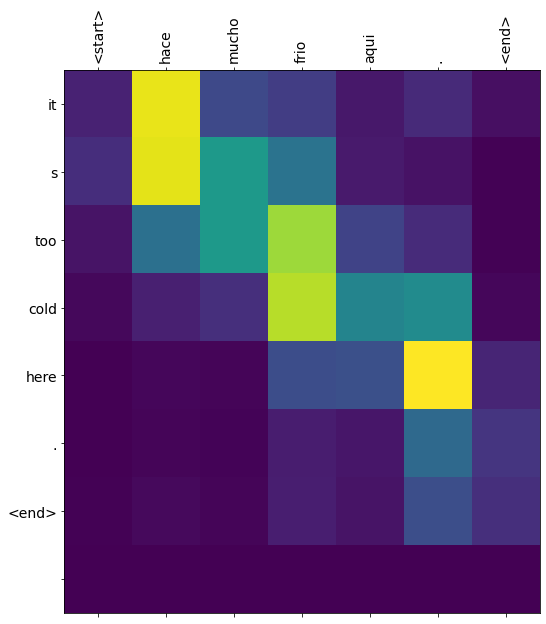

In [ ]:
translate(u'hace mucho frio aqui.')

Input: <start> esta es mi vida . <end>
Predicted translation: this is my life . <end> 


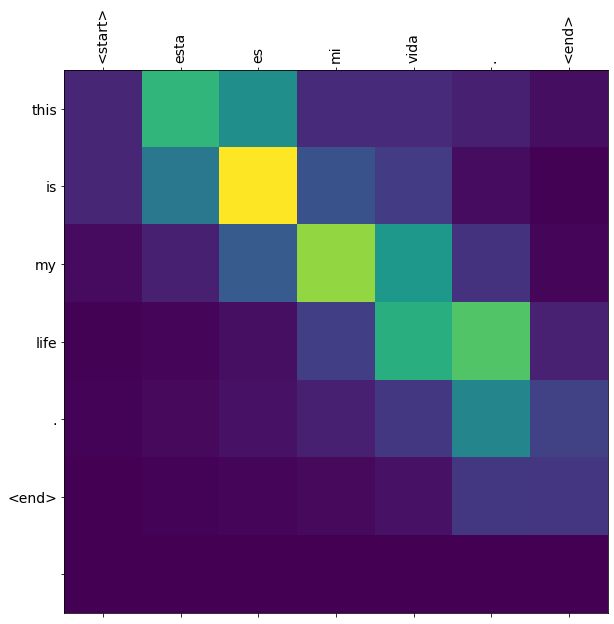

In [ ]:
translate(u'esta es mi vida.')

Input: <start> ¿ todavia estan en casa ? <end>
Predicted translation: are you still at home ? <end> 


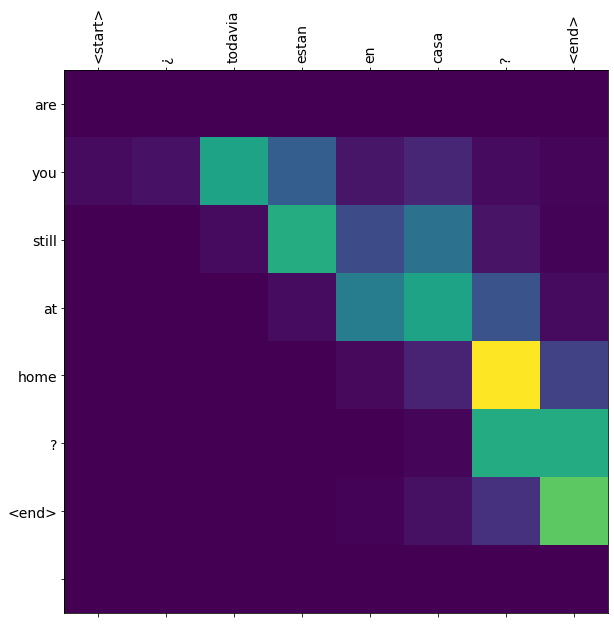

In [ ]:
translate(u'¿todavia estan en casa?')

Input: <start> trata de averiguarlo . <end>
Predicted translation: try to figure it out . <end> 


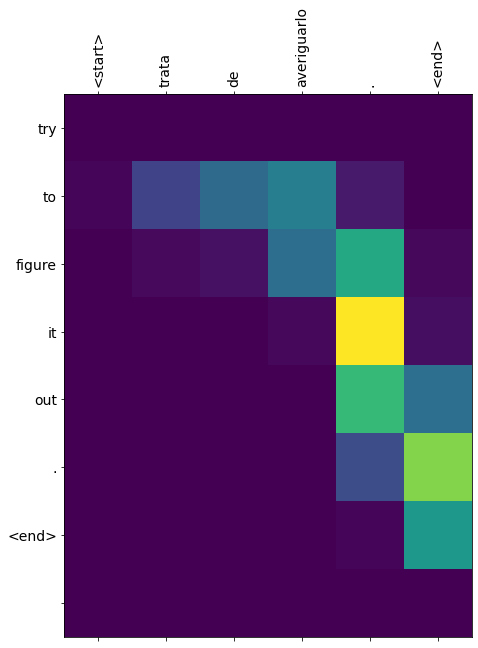

In [ ]:
# wrong translation
translate(u'trata de averiguarlo.')

### Optional: Implement Attention Yourself

Use this as your attention layer if you want to implement it yourself.


In [ ]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super().__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.W3 = tf.keras.layers.Dense(1)

    def call(self, query, values):
        # query hidden state shape == (batch_size, hidden size)
        # query_with_time_axis shape == (batch_size, 1, hidden size)
        # values shape == (batch_size, max_len, hidden size)
        # we are doing this to broadcast addition along the time axis to calculate the score
        query_with_time_axis = tf.expand_dims(query, 1)

        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.W3
        # the shape of the tensor before applying self.W3 is (batch_size, max_length, units)
        score = self.W3(tf.nn.tanh(
            self.W1(query_with_time_axis) + self.W2(values)))

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [ ]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))